# Investigating Investment Properties in Durham, NC

## Objective:
This project aims to create a tool for finding investment worthy properties (properties to be bought and rented out) in Durham, North Carolina.

## Acquiring data from Zillow

In [1]:
import scrapeAndCompileHousingData

In [ ]:
scrapeAndCompileHousingData.main()

The function above runs the functions <a href=https://github.com/adampely/zillowHousingDataScrape/blob/master/requestBasedScrape.py> requestBasedScrape </a> which takes as input any map on Zillow and finds all the houses in the map across as many pages as requested, and <a href=https://github.com/adampely/zillowHousingDataScrape/blob/master/zillowAPI3.py>  retrieveHouseData </a> which takes as an input the addresses found from requestBasedScrape and runs them through the Zillow API to get a set of parameters on each house which currently includes: [city, zipcode, address, latitude, longitude,zpid, bathrooms, bedrooms, sqft, hometype, taxAssessmentYear, taxAssessment, zestimate,	rentzestimate, real rent]
and places the parameters in a csv file.
An example of the zillow map can be seen below.

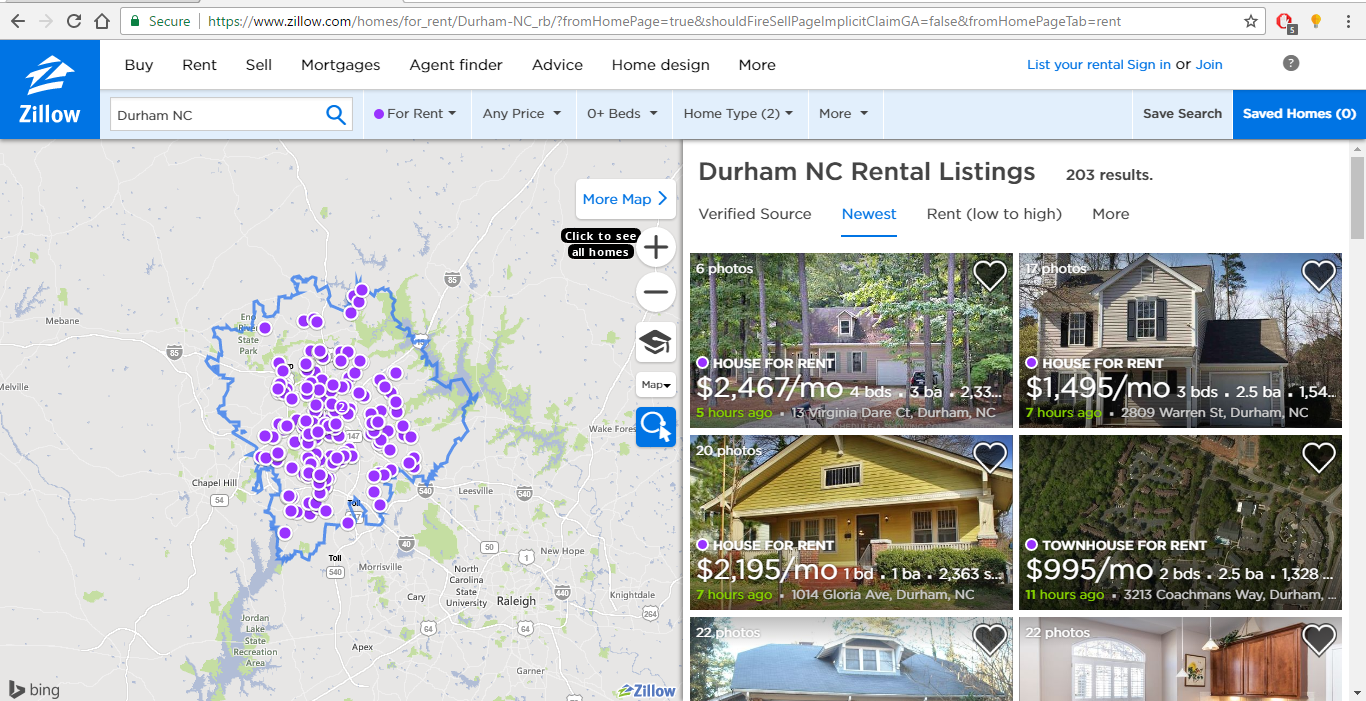

In [ ]:
from IPython.display import Image 
Image(filename='zillowScreenshot.png') 

## Sanity Checking the data

In [ ]:
import pandas as pd
import numpy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.stats.api import ols

In [ ]:
house_data = pd.read_csv('allDurhamDataWithCoords.csv', index_col=0, thousands=',')
X = house_data[['bedrooms', 'bathrooms', 'sqft']]
house_price = house_data['zestimate']
house_rent = house_data['real rent']
house_price_rent_ratio = house_rent / house_price
house_data['rentToPrice'] = house_price_rent_ratio
print('dataset contains: ', sum(house_data['homtype']=='SingleFamily'), 'single family homes')
print('dataset contains: ', sum(house_data['homtype']=='Townhouse'), 'townhouse homes')
house_data.head(3)

In [ ]:
sortedByBedrooms = [];
numBedrooms = [];
#This for loop is here to sort the bedroom data into lists based on number of bedrooms
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_data.zestimate[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)
numBedrooms

In [ ]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.title('price as a function of bedrooms')
plt.xticks(range(1,max(numBedrooms)), numBedrooms)
plt.tight_layout()
plt.show()

Above we see a standard breakdown of price vs. square footage and the price vs. the number of bedrooms. Everything follows the trends we would expect the data to follow.

In [ ]:
for i in numBedrooms:
    if i==2: 
        markColor='ro'
    elif i==3: 
        markColor='bo' 
    elif i==4: 
        markColor='go'
    elif i==5: 
        markColor='ko'
    plt.plot(X[X['bedrooms']==i]['sqft'], house_price[X['bedrooms']==i], markColor, alpha=0.7, label=str(i))
plt.legend(loc=2)
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')

plt.show()

This plot shows that there is also a correlation between number of bedrooms and house size, with the legend indicated number of bedrooms. Therefore, it is hard to state whether it is house size or number of bedrooms that dictate the price. This will come up again in later analysis. This also shows that we are dealing mostly with 2, 3, and 4 bedroom houses.

## Investment Properties and Rent to Buy Ratio

As stated in the objective, this project aims to find good investment properties, or those that can be rented out for a high price relative to the purchase price. This is where the rent:buy ratio becomes important, with a higher ratio indicating better returns.

In [ ]:
sortedByBedrooms = [];
numBedrooms = [];
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_price_rent_ratio[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)

In [ ]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price_rent_ratio, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('rent:buy ratio')
plt.title('rent:buy ratio as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xticks(range(1,5), numBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('rent:buy ratio')
plt.title('rent:buy ratio as a function of bedrooms')

plt.tight_layout()
plt.show()

Here we can see the opposite of the trend previously observed, where suddenly it seems as though smaller properties with less bedrooms provide the best return on investment.

In [ ]:
twoBedSingleFam = house_data[(house_data['homtype']=='SingleFamily') & (house_data['bedrooms']==3) & (house_data['bathrooms']==2.5)]
twoBedTownhouse = house_data[(house_data['homtype']=='Townhouse') & (house_data['bedrooms']==3) & (house_data['bathrooms']==2.5)]
box1 = twoBedTownhouse['rentToPrice']
box2 = twoBedSingleFam['rentToPrice']
plt.boxplot([box1, box2])
plt.xticks(range(1,3),['Townhouse', 'Single Family'])
plt.xlabel('Home type')
plt.ylabel('rent:buy ratio')
plt.title('rent:buy ratio as a function of house type in 3 bed 2.5 bath units')
plt.show()

This plot shows that between similar house layouts, there is a difference between townhomes and single family properties. This could also be another important parameter in determining the investment value of a property.

In [ ]:
#seeing how rent to price ratio is distributed
plt.hist(house_data['rentToPrice'],
         range=[min(house_data['rentToPrice']),
                max(house_data['rentToPrice'])])
plt.show()

## Lasso Regression Model:
Now there we have a sense for the data, I decided to look into fitting a model. Lasso regression is an iterative linear regression method that allows for the elimination of unnecessary parameters and gives a good estimate of relative importance of each parameter.

In [ ]:
from sklearn.cross_validation import train_test_split
import sklearn.metrics
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing

In [ ]:
house_data=house_data[house_data['homtype']!='Condominium']
house_data=house_data.dropna()
#townhouse is now set to 1 and single family home will be 0
house_data['homeTypeBinary']=(house_data['homtype'] == 'Townhouse').astype(int)

In [ ]:
feature_names=['latitude',
'longitude',
'bathrooms',
'bedrooms',
'sqft',
'homeTypeBinary']
predictors = house_data[feature_names]

In [ ]:
targets = house_data.rentToPrice
predNorm=predictors.copy()
for feature in feature_names:
    predNorm[feature]=preprocessing.scale(predNorm[feature].astype('float64'))

In [ ]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predNorm, targets, 
                                                              test_size=.3, random_state=122)

In [ ]:
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

In [ ]:
dict(zip(predictors.columns, model.coef_))

Above we see that the regression model found bedrooms to not be a useful parameter while the other parameters were found to be meaningful. The order of importance here is determined by the coefficient and so is:
1. sqft
2. home type
3. latitude
4. bathrooms
5. lonitude

In [ ]:
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

The R-quare values here indicates how well the curve fits the data, and it appears to fit it somewhat, but not very well. This makes sense as we are assuming a linear relationship with every parameter which may not exist.

## Decision Tree Model

To get around the linearity assumption of the regression model I decided to use a random forest method. Random forests are made up of many decision trees, which are used to predict outcomes of a set of parameters by splitting them into branches. They require a binary outcome, which is why in this case I will classify houses in the top quartile of best rent:buy ratios as 1 and all the rest of the properties as 0.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [ ]:
house_data['binaryRentToPrice']=house_data['rentToPrice']<house_data['rentToPrice'].quantile(0.75)

In [ ]:
predictors = house_data[feature_names]
targets = house_data.binaryRentToPrice

In [ ]:
pred_train, pred_test, tar_train, tar_test  =   train_test_split(predictors, targets, test_size=.3, random_state=13)

In [ ]:
classifier=DecisionTreeClassifier()
classifier=classifier.fit(pred_train,tar_train)
predictions=classifier.predict(pred_test)
print(sklearn.metrics.confusion_matrix(tar_test,predictions))
print(sklearn.metrics.accuracy_score(tar_test, predictions))

The confusion matrix above can be interpreted such that the top right corner are homes that were correctly identified as being in the top quartile for rent to price ratio, the bottom right was identified as having correctly placed homes that were not in the top 25% highest rent to price ratio in that category, the bottom left corner are false positives and the top right corner are false negatives. The accuracy score is better than random, but the confusion matrix is not exactly reassuring as we seem only slightly better than chance to correctly predict a house that is truly a good value. I think part of this has to do with my random division along the 25th percentile in a category that is continuous. I will still try to run a random forest but lasso regression may work better.

In [ ]:
from sklearn import tree
#from StringIO import StringIO
from io import StringIO
#from StringIO import StringIO 
from IPython.display import Image
out = StringIO()
tree.export_graphviz(classifier, out_file=out, feature_names=feature_names)
import pydotplus
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

## Random Forest Model

In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics
 # Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier=RandomForestClassifier(n_estimators=25)
classifier=classifier.fit(pred_train,tar_train)

In [ ]:
predictions=classifier.predict(pred_test)

print(sklearn.metrics.confusion_matrix(tar_test,predictions))
print(sklearn.metrics.accuracy_score(tar_test, predictions))


Lower false positives and less false negatives! The random forest using the same data set clearly improved on the decision tree's previous performance. This is an expected and welcome result, however the complete absense of false positives means that if the algorithm tells you a place is a good investment property, it is very likely to be a good investment property. This is a pretty handy feature in the Durham housing market.

## Mapping Location:
I saw that previously latitude and longitude in the lasso regression were considered important features, so I want to see if there is a grouping of good rent:buy houses in Durham. I moved the cordinates of the good value houses onto one map the the bad value houses onto another. 

In [ ]:
house_data = house_data.sort(columns = 'rentToPrice', ascending = False)
best_rent_to_price = house_data.head(int(len(house_data)/4))
worst_rent_to_price = house_data.tail(3*int(len(house_data)/4))

In [ ]:
import codecs
fhand = codecs.open('where.js','w', "utf-8")
fhand.write("myData = [\n")
count = 0
for entry in best_rent_to_price.iterrows():
    lat = entry[1][2]
    lng = entry[1][3]
    where = entry[1][1]
    if count > 1 : fhand.write(",\n")
    output = "["+str(lat)+","+str(lng)+", '"+where+"'],"
    fhand.write(output)
    
fhand.write("\n];\n")
fhand.close()

fhand = codecs.open('whereBad.js','w', "utf-8")
fhand.write("myData = [\n")
count = 0
for entry in worst_rent_to_price.iterrows():
    lat = entry[1][2]
    lng = entry[1][3]
    where = entry[1][1]
    if count > 1 : fhand.write(",\n")
    output = "["+str(lat)+","+str(lng)+", '"+where+"'],"
    fhand.write(output)
    
fhand.write("\n];\n")
fhand.close()

In [ ]:
from IPython.display import display
from IPython.display import HTML
from IPython.display import IFrame
#HTML('<iframe src="./where.html" width=1000 height=1000></iframe>')
IFrame('where.html', width=700, height=500)

In [ ]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='housingMapWorst.png') 
y = Image(filename='housingMapBest.png') 
display(x, y)

We can see that the location of the house is very important in determining the investment quality of the property. However, we also see that this is a non-linear relationship and that it appears to cluster in the center of Durham. Because of this, the linear regression methods used were not very good for fitting the data. This might also explain why random forests were so good at picking out good value properties, since they are designed to find non-linear relationships.
A new parameter should be introduced. The coordinates for the center of the center of Durham by way of a google search were 35.9940° N, 78.8986° W. Based on my knowledge of the city that appears to be centered in the downtown area. A new parameter called distance to city center will be added. 

## Adding Distance from City Center Parameter

In [ ]:
durhamCenterLat = 35.994043
durhamCenterLong = -78.898611
house_data['dFromCentLat'] = house_data['latitude']-durhamCenterLat
house_data['dFromCentLong'] = house_data['longitude']-durhamCenterLong
house_data['distanceFromCityCenter'] = numpy.sqrt(house_data['dFromCentLat'] ** 2 +
                                        house_data['dFromCentLong'] ** 2)
feature_names=['distanceFromCityCenter',
'bathrooms',
'bedrooms',
'sqft',
'homeTypeBinary']

## Lasso Regression With Distance Parameter

In [ ]:
predictors = house_data[feature_names]
targets = house_data.rentToPrice
predNorm=predictors.copy()
for feature in feature_names:
    predNorm[feature]=preprocessing.scale(predNorm[feature].astype('float64'))

In [ ]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predNorm, targets, 
                                                              test_size=.3, random_state=122)

In [ ]:
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

In [ ]:
dict(zip(predictors.columns, model.coef_))

Now the order of importance has changed to be:
1. distance from city center
2. home type
3. square footage
4. bathrooms

In [ ]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

This is a huge improvement over the previous R-square values acheived, meaning we are seeing a stronger correlation and fitting the data much better.

## Conclusion

Overall, it was shown that in Durham a small (square footage-wise) townhouse near the center of Durham is the best investment property to purchase. However, this generalization falls short in a number of areas, the most prominent of which is the relatively small data set.